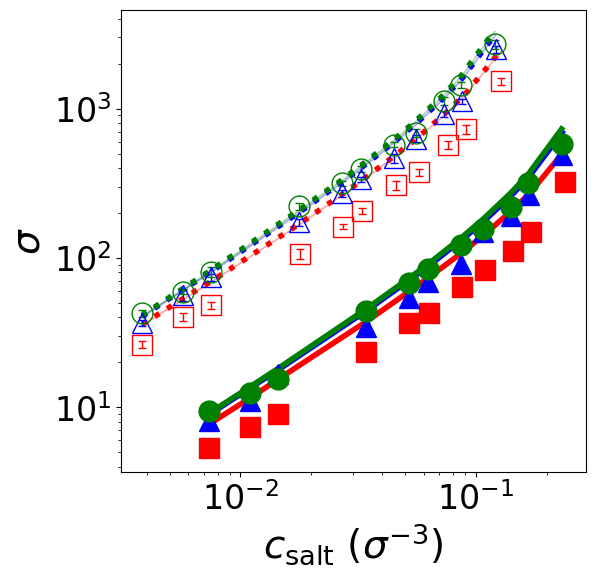

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd

def NE_cond(Diffusion1, Diffusion2, Diff_err1, Diff_err2, r_value = [0.01, 0.015, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.8]):
    """
    Nernst-Einstein conductivity with error propagation.
    Parameters
    ----------
    Diffusion1, Diffusion2 : array-like
        Diffusion coefficients of cation and anion
    Diff_err1, Diff_err2 : array-like
        Standard errors of Diffusion1 and Diffusion2
    r_value : array-like
        Salt ratio (r = n_ion / n_solvent)
    Returns
    -------
    NEcond, NEcond_err : np.ndarray
        Conductivity and propagated error
    """
    D1 = np.array(Diffusion1)
    D2 = np.array(Diffusion2)
    D1_err = np.array(Diff_err1)
    D2_err = np.array(Diff_err2)
    r_value = np.array(r_value)

    D_mean = (D1 + D2) / 2
    D_err = 0.5 * np.sqrt(D1_err**2 + D2_err**2)  # error propagation of mean

    n_ion = r_value * 5000
    NEcond = D_mean * 2 * n_ion
    NEcond_err = 2 * n_ion * D_err  # propagate linearly

    return NEcond, NEcond_err

# ---------- Load reference x-data (rho_salt) ---------- #
base_dir = "./" 
os.chdir(base_dir)


concentrate_file = f"{base_dir}concentrate_volume.csv"
concentrate_data = pd.read_csv(concentrate_file)
for col in concentrate_data.columns:
    globals()[col] = concentrate_data[col].dropna().to_numpy()

# ---------- Color & marker mapping ---------- #
color_map = {'0.2': 'red', '1': 'blue', '5': 'green'}
marker_map = {'0.2': 's', '1': '^', '5': 'o'}

fig, ax = plt.subplots(figsize=(6, 6))


for eps in ['0.2', '1', '5']:
    for pot in ['LJ', 'WCA']:
        fname = f"Sigma_fit_MD_{eps}_{pot}.csv"
        df = pd.read_csv(fname)

        # --- x = a / λ_D --- #
        if eps=="0.2":
            eps_temp = "02"
            if pot=="LJ":
                pot_temp = "lj"
            else:
                pot_temp = "wca"
        else:
            eps_temp = eps
            if pot=="LJ":
                pot_temp = "lj"
            else:
                pot_temp = "wca"

        x = f"mean_c_salt_{eps_temp}_{pot_temp}"
        x = globals()[x]

        # --- y = sigma --- #
        y = df["sigma_fit"]
        y = np.array(y)

        # --- Error propagation --- #
        sigma_fit = df["sigma_fit"].to_numpy()
        sigma_fit_err = df["sigma_fit_err"].to_numpy()


        # --- Marker style --- #
        filled = (pot == "LJ")
        ax.errorbar(
            x, y, yerr=sigma_fit_err,
            fmt=marker_map[eps],
            markersize=15,
            color=color_map[eps],
            mfc=color_map[eps] if filled else 'none',
            mec=color_map[eps],
            ecolor=color_map[eps],
            elinewidth=1,
            capsize=3,
            label=f"{eps} {pot}"
        )
        
        diffusion_name = f"Diffusion_fit_MD_{eps}_{pot}.csv"
        diffusion_data = pd.read_csv(diffusion_name)
        D_cat = diffusion_data["Dpp"]
        D_cat_err = diffusion_data["Dpp_err"]
        D_ani = diffusion_data["Dmm"]
        D_ani_err = diffusion_data["Dmm_err"]

        NE_data, NE_err = NE_cond(D_cat, D_ani, D_cat_err, D_ani_err)

        solid = (pot=="LJ")
        ax.plot(x, NE_data, color=color_map[eps], linewidth=4, linestyle = "-" if solid else ":")
        ax.fill_between(x, NE_data-NE_err, NE_data+NE_err, color = color_map[eps], alpha=0.3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=24)
ax.set_xlabel(r'$c_{\mathrm{salt}}$ $(\sigma^{-3})$', fontsize=28)
ax.set_ylabel(r'$\sigma$', fontsize=28)

plt.show()